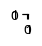

In [1]:
import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
f,a = plt.subplots(1,1,figsize=(1e-2, 1e-2))
mpl.rcParams['figure.dpi'] = 150
sns.set_style('darkgrid')
import os,sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
import warnings
warnings.filterwarnings("ignore")
import glob
from tqdm.auto import tqdm
from datetime import datetime as dt

# Load models together
from src.torch_utils import load_model_full
from src.utils import get_class_initcode_keys
from torch.utils.data import SequentialSampler
from src.datasets import *
from src.models import *
%load_ext autoreload
%autoreload 2
    
from src.utils import mkdirs, convert_path, pkl_dump, pkl_load, add_median_labels, get_palette
from src.data_processing import BL62_VALUES, BL62FREQ_VALUES, HLAS, AA_KEYS
from src.utils import pkl_load, pkl_dump, get_palette
from src.sim_utils import make_dist_matrix
from sklearn.cluster import AgglomerativeClustering
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_auc_score
from src.torch_utils import save_checkpoint, load_checkpoint
from src.train_eval import predict_model, train_eval_loops
from src.models import FullTCRVAE, TwoStageVAECLF
from src.metrics import get_metrics, reconstruction_accuracy, compute_cosine_distance
from src.datasets import TCRSpecificDataset, FullTCRDataset
import torch
import glob
from torch import optim
from torch.utils.data import RandomSampler, SequentialSampler
from torch import nn
from torch.nn import functional as F
mpl.rcParams['figure.dpi'] = 180


In [27]:
df = pd.read_csv('../data/filtered/240418_nettcr_expanded_20binders_17pep_POSONLY.csv')
cs = ['A1','A2','A3','B1','B2','B3']
for c in cs:
    l = df[c].apply(len)
    print(c)
    display(l.describe())

A1


count    7340.000000
mean        5.988011
std         0.571731
min         5.000000
25%         6.000000
50%         6.000000
75%         6.000000
max         7.000000
Name: A1, dtype: float64

A2


count    7340.000000
mean        6.675749
std         1.010524
min         4.000000
25%         6.000000
50%         7.000000
75%         7.000000
max         8.000000
Name: A2, dtype: float64

A3


count    7340.000000
mean       11.434605
std         2.099890
min         3.000000
25%        10.000000
50%        11.000000
75%        13.000000
max        22.000000
Name: A3, dtype: float64

B1


count    7340.000000
mean        5.080245
std         0.271691
min         5.000000
25%         5.000000
50%         5.000000
75%         5.000000
max         6.000000
Name: B1, dtype: float64

B2


count    7340.000000
mean        6.089101
std         0.322590
min         5.000000
25%         6.000000
50%         6.000000
75%         6.000000
max         7.000000
Name: B2, dtype: float64

B3


count    7340.000000
mean       12.425749
std         1.761287
min         5.000000
25%        11.000000
50%        12.000000
75%        13.000000
max        23.000000
Name: B3, dtype: float64

# triplet error

In [70]:
input1 = torch.randn(100, 128)
input2 = torch.randn(100, 128)
cos = nn.CosineSimilarity(dim=1, eps=1e-6)
output = cos(input1, input2)

In [219]:
distances = pkl_load('/Users/riwa/Documents/code/total_dis.pkl')
pos_dis = pkl_load('/Users/riwa/Documents/code/pos_dis.pkl')
pos_mask = pkl_load('/Users/riwa/Documents/code/pos_mask.pkl')
neg_dis = pkl_load('/Users/riwa/Documents/code/neg_dis.pkl')
neg_mask = pkl_load('/Users/riwa/Documents/code/neg_mask.pkl')
labels = pkl_load('/Users/riwa/Documents/code/labels.pkl')
loss = pkl_load('/Users/riwa/Documents/code/loss.pkl')

In [220]:
diag_mask = torch.ones_like(pos_mask).fill_diagonal_(0)
mask_loss = torch.mul(loss, diag_mask)

In [ ]:
import pickle

with open('/Users/riwa/Documents/code/pos_dis.pkl', 'wb') as f:
    pickle.dump(positive_distances, f)

with open('/Users/riwa/Documents/code/neg_dis.pkl', 'wb') as f:
    pickle.dump(negative_distances, f)
    
with open('/Users/riwa/Documents/code/pos_mask.pkl', 'wb') as f:
    pickle.dump(mask_positive, f)
    
with open('/Users/riwa/Documents/code/neg_mask.pkl', 'wb') as f:
    pickle.dump(mask_negative, f)

with open('/Users/riwa/Documents/code/labels.pkl', 'wb') as f:
    pickle.dump(labels, f)

with open('/Users/riwa/Documents/code/loss.pkl', 'wb') as f:
    pickle.dump(loss, f)

with open('/Users/riwa/Documents/code/total_dis.pkl', 'wb') as f:
    pickle.dump(pairwise_distances, f)

In [221]:
# loss = F.relu(pos - neg + 0.1)
def get_vector(loss, pos, neg, i, margin=0.1):
    where = torch.where(loss[i]>0)[0]
    pp = pos[i][where]
    nn = neg[i][where]
    ll = loss[i][where]
    print('pos\n\t', pp)
    print('neg\n\t', nn)
    print('loss\n\t', ll)
    print('minus\n\t', pp-nn+margin)
    print('final loss\n\t', F.relu(pp-nn+margin))
    print('where\n\t', where)
    return pp, nn, ll

In [235]:
(labels==11).float().sum()

tensor(12.)

In [258]:
pp,nn,ll = get_vector(mask_loss, pos_dis, neg_dis, 251, margin = 0.6)

pos
	 tensor([0.4451, 1.2796, 0.0000, 1.3656, 0.0000, 0.8558],
       grad_fn=<IndexBackward0>)
neg
	 tensor([0.0000, 0.0000, 0.0897, 0.0000, 0.0905, 0.0000],
       grad_fn=<IndexBackward0>)
loss
	 tensor([0.5451, 1.3796, 0.0103, 1.4656, 0.0095, 0.9558],
       grad_fn=<IndexBackward0>)
minus
	 tensor([1.0451, 1.8796, 0.5103, 1.9656, 0.5095, 1.4558],
       grad_fn=<AddBackward0>)
final loss
	 tensor([1.0451, 1.8796, 0.5103, 1.9656, 0.5095, 1.4558],
       grad_fn=<ReluBackward0>)
where
	 tensor([ 68, 273, 338, 392, 422, 510])


In [253]:
margin=0.4452
pp-nn+margin, F.relu(pp - nn + margin)

(tensor([0.8903, 1.7248, 0.3555, 1.8108, 0.3547, 1.3010],
        grad_fn=<AddBackward0>),
 tensor([0.8903, 1.7248, 0.3555, 1.8108, 0.3547, 1.3010],
        grad_fn=<ReluBackward0>))

In [139]:
class_matrix = labels.view(-1,1)
positive_mask = (class_matrix == class_matrix.t()).float()
negative_mask = (class_matrix != class_matrix.t()).float()

# Make diagonal elements zero in positive mask since an anchor shouldn't select itself
positive_mask.fill_diagonal_(0)
positive_mask, negative_mask

(tensor([[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]),
 tensor([[0., 1., 1.,  ..., 1., 1., 1.],
         [1., 0., 1.,  ..., 1., 1., 1.],
         [1., 1., 0.,  ..., 1., 1., 1.],
         ...,
         [1., 1., 1.,  ..., 0., 1., 1.],
         [1., 1., 1.,  ..., 1., 0., 1.],
         [1., 1., 1.,  ..., 1., 1., 0.]]))

In [160]:
positive_distances = distances * positive_mask
hardest_positive_distances = positive_distances.max(dim=1)[0]

In [163]:
positive_distances[0, [129,245,341]]

tensor([1.1594, 0.9830, 1.0951], grad_fn=<IndexBackward0>)

In [162]:
torch.where(positive_distances>0)

(tensor([  0,   0,   0,  ..., 470, 470, 470]),
 tensor([129, 245, 341,  ..., 354, 379, 428]))

In [164]:
negative_distances = distances * negative_mask
# Replace zero with large number where negative_mask is zero
max_distance = distances.max().item() + 1
negative_distances += max_distance * (1 - negative_mask)
hardest_negative_distances = negative_distances.min(dim=1)[0]

In [172]:
triplet_loss = hardest_positive_distances - hardest_negative_distances + 0.1
triplet_loss = F.relu(triplet_loss)
valid_triplets = (positive_mask.sum(dim=1) > 0) & (negative_mask.sum(dim=1) > 0)


In [180]:
positive_mask[253]

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 

In [179]:
torch.where(valid_triplets==False)

(tensor([253]),)

In [166]:
negative_distances

tensor([[2.5964, 1.1194, 1.2056,  ..., 0.5992, 0.7681, 1.0439],
        [1.1194, 2.5964, 1.2990,  ..., 1.3319, 1.0508, 0.8547],
        [1.2056, 1.2990, 2.5964,  ..., 1.1263, 1.1149, 0.8849],
        ...,
        [0.5992, 1.3319, 1.1263,  ..., 2.5964, 0.9528, 0.9223],
        [0.7681, 1.0508, 1.1149,  ..., 0.9528, 2.5964, 1.1386],
        [1.0439, 0.8547, 0.8849,  ..., 0.9223, 1.1386, 2.5964]],
       grad_fn=<AddBackward0>)

In [165]:
max_distance

2.5963759422302246

# tests architectures

In [10]:
# 5k datapoints, len 50, 20 aa dim
x = torch.rand(1000, 50, 20)

In [11]:
x.permute(0,2,1).shape

torch.Size([1000, 20, 50])

In [17]:
# Taking 5 n_hidden
conv1 = nn.Conv1d(20, 10, kernel_size=5, stride=1)
mp = nn.MaxPool1d(kernel_size=4, stride=2)
conv2 = nn.Conv1d(10, 20, kernel_size=5, stride=1)

z = conv1(x.permute(0,2,1))
print(z.shape)
z = mp(z)
print(z.shape)
z = conv2(z)
print(z.shape)

torch.Size([1000, 10, 46])
torch.Size([1000, 10, 22])
torch.Size([1000, 20, 18])


In [ ]:
class CNNEncoder(nn.Module):
    def __init__(self, n_features, hidden_dim, latent_dim, kernel_size):
        super(CNNEncoder, self).__init__()
        


In [69]:
import torch
from torch import nn

class CNNEncoder(nn.Module):
    def __init__(self, L, num_features, hidden_dims, latent_dim):
        super(CNNEncoder, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv1d(num_features, hidden_dims, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool1d(2, stride=2),
            nn.Conv1d(hidden_dims, hidden_dims * 2, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool1d(2, stride=2)
        )
        self.flatten = nn.Flatten()
        self.fc_mu = nn.Linear(hidden_dims * 2 * (L // 4), latent_dim)  # Adjust size accordingly
        self.fc_var = nn.Linear(hidden_dims * 2 * (L // 4), latent_dim)  # Adjust size accordingly

    def forward(self, x):
        x = x.permute(0, 2, 1)  # Adjusting dimensions to (N, C, L)
        x = self.conv_layers(x)
        x = self.flatten(x)
        mu = self.fc_mu(x)
        log_var = self.fc_var(x)
        return mu, log_var

class CNNDecoder(nn.Module):
    def __init__(self, L, num_features, hidden_dims, latent_dim):
        super(CNNDecoder, self).__init__()
        self.fc = nn.Linear(latent_dim, hidden_dims * 2 * (L // 4))  # Adjust size accordingly
        self.conv_transpose_layers = nn.Sequential(
            nn.ConvTranspose1d(hidden_dims * 2, hidden_dims, kernel_size=6, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose1d(hidden_dims, num_features, kernel_size=6, stride=2, padding=1),
            nn.ReLU()
        )
        self.hidden_dims = hidden_dims
        self.L = L

    def forward(self, z):
        x = self.fc(z)
        x = x.view(-1, self.hidden_dims * 2, self.L // 4)  # Reshape to (N, C, L) for ConvTranspose
        x = self.conv_transpose_layers(x)
        x = x.permute(0, 2, 1)  # Reshaping back to (N, L, C)
        return x

class VAE(nn.Module):
    def __init__(self, L, num_features, hidden_dims, latent_dim):
        super(VAE, self).__init__()
        self.encoder = CNNEncoder(L, num_features, hidden_dims, latent_dim)
        self.decoder = CNNDecoder(L, num_features, hidden_dims, latent_dim)

    def reparameterize(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        mu, log_var = self.encoder(x)
        z = self.reparameterize(mu, log_var)
        x_recon = self.decoder(z)
        return x_recon, mu, log_var

x = torch.rand(1000, 50, 20)
v = VAE(50, 20, 128, 64)
x_hat, mu, logvar = v(x)

x_hat.shape, mu.shape, logvar.shape

(torch.Size([1000, 54, 20]), torch.Size([1000, 64]), torch.Size([1000, 64]))